In [41]:
import json

!wget https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
with open("imagenet-simple-labels.json", "r") as f:
  labels = json.load(f)

--2023-05-09 12:51:37--  https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14193 (14K) [text/plain]
Saving to: ‘imagenet-simple-labels.json.1’

imagenet-simple-lab 100%[===================>]  13.86K  --.-KB/s    in 0.001s  

2023-05-09 12:51:37 (22.4 MB/s) - ‘imagenet-simple-labels.json.1’ saved [14193/14193]



In [34]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount('/content/drive/MyDrive/assignment_4/')

Mounted at /content/drive


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
net = resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 85.7MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#print(net)

## 1.1: Download code for class activation mapping (CAM and/or grad-CAM)

In [48]:
%matplotlib inline

from PIL import Image,ImageChops
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform

In [ ]:
# Imagenet mean/std

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# Preprocessing - scale to 224x224 for model, convert to tensor, 
# and normalize to -1..1 with mean/std for ImageNet

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

display_transform = transforms.Compose([
   transforms.Resize((224,224))])

In [46]:
model = net
# model = models.resnet50(pretrained=True)
model.cuda()
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

final_layer = model._modules.get('layer4')
activated_features = SaveFeatures(final_layer)

In [55]:
from typing import Callable, Optional

In [90]:
import torch

In [98]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

weight_softmax_params

def imageWithCam(imgPath, requires_grad=True, nofPred=1,
                 transform: Optional[Callable] = None):
  """
  Plots the image with cam, possibly applying a transformation
  to the image before
  """

  fig, ax = plt.subplots(dpi=300)
  image = Image.open(imgPath)
  if np.array(image).shape[2]==4:
    image = image.convert('RGB')

  tensor = preprocess(image)
  
  if transform is not None:
    tensor = transform(tensor)
    #image = Image.fromarray(transform(torch.Tensor(np.asarray(image))).numpy())

  prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad)
  prediction = model(prediction_var)
  pred_probabilities = F.softmax(prediction).data.squeeze()
  activated_features.remove()
  #print(topk(pred_probabilities,nofPred))
  class_idx = topk(pred_probabilities,nofPred)[1].int()
  #print(class_idx)
  overlay = getCAM(activated_features.features, weight_softmax, class_idx[nofPred-1])
  # Print the predicted label
  print(f"Predicted label: {labels[class_idx]}")

  #print(class_idx[nofPred-1])
  ax.imshow(overlay[0], alpha=0.5, cmap='jet')
  ax.imshow(display_transform(image))
  ax.imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet')
  
  plt.show()
  #return fig

## 1.2. Get 3 images from the internet and see how the attention maps for the prediction of the network change

In [81]:
# Set base path for imgs
base_path = "drive/MyDrive/assignment_4/cam_imgs"

imgs = {
    "zebra":f"{base_path}/zebra.jpg",
    "pipe_organ":f"{base_path}/pipe_organ.jpg",
    "piggy_bank":f"{base_path}/piggy_bank.jpg",
    "group_1": f"{base_path}/group_photo_1.png",
    "group_2": f"{base_path}/group_photo_2.png"
}

#for name, img in imgs.items():
#  imgs[name] = imageWithCam(img, requires_grad=True, nofPred=1)

### 1.2.1: Affine Image transformations, i.e., rotation, flipping, shift etc.

In [53]:
from torchvision import datapoints
from torchvision.io import read_image
import torch
import numpy as np

torch.manual_seed(123)
transform1 = transforms.Compose(
    [
        transforms.RandomRotation(180),
    ]
)


### 1.2.2: Additive noise, i.e., salt and pepper noise, gaussian filtering, median blur, unsharp filter

In [67]:
import torch
def add_gaussian_noise(y, mean=0, std=150/255):
    # x = np.array(y)
    # print(type(x))
    noise = torch.randn(y.shape) * std + mean
    return (y + noise).clamp(0, 1) # * 255

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: add_gaussian_noise(x, mean=0, std=150/255)),
    transforms.ToPILImage()
])



In [60]:
#imgs["zebra"]

<class 'PIL.JpegImagePlugin.JpegImageFile'>
Predicted label: zebra


<ipython-input-86-a77c1aae0d70>:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probabilities = F.softmax(prediction).data.squeeze()


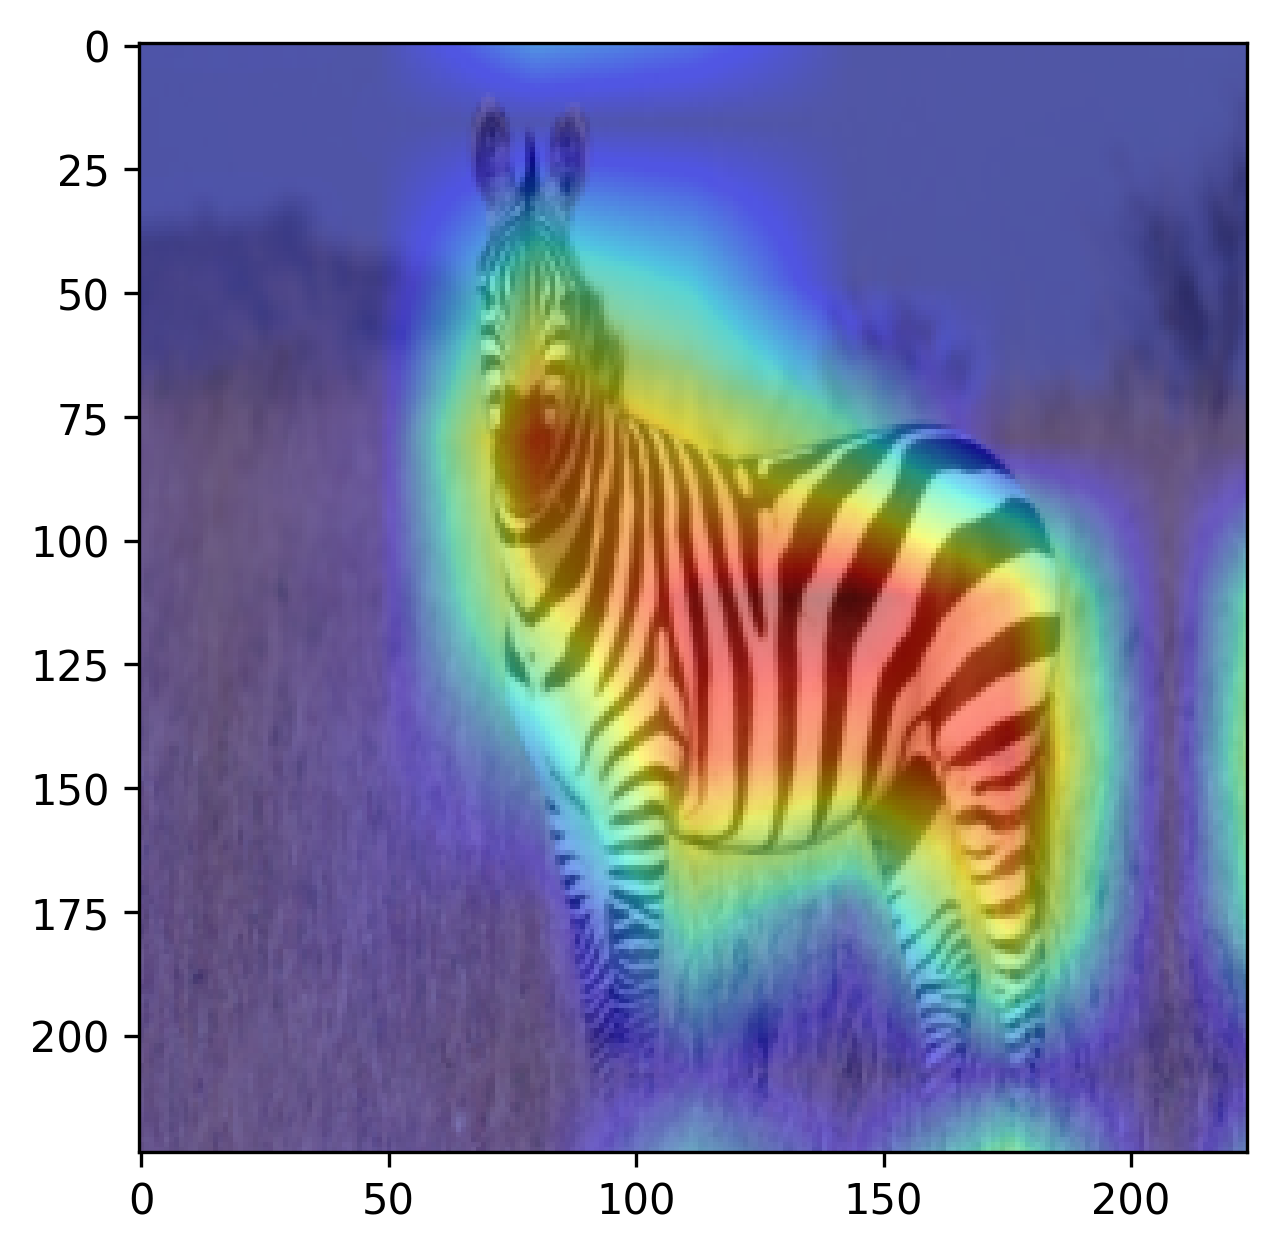

In [87]:
imageWithCam(imgs["zebra"], requires_grad=True, nofPred=1)

In [99]:
#imageWithCam(imgs["zebra"], requires_grad=True, nofPred=1, transform=add_gaussian_noise)

### 1.2.3: Intensity transformation, i.e, flipping the RGB channels, histogram equalization 

In [ ]:
def transform_img(transformation):

  return transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(lambda x: transformation(x))
  ])

torch.Size([3, 1341, 2048])
(1341, 2048, 3)


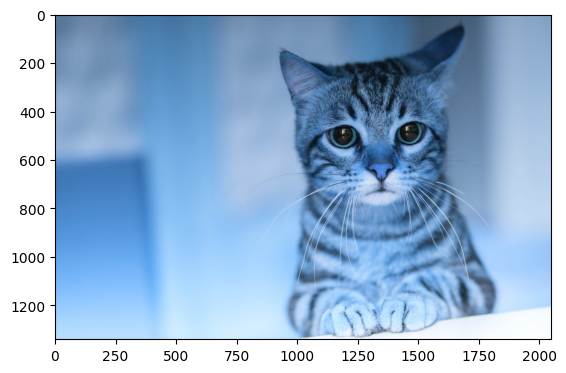

In [ ]:
def flipRGB(image):
    print(image.shape)
    image_new  = image[[2,1,0],...]
    return image_new

transform3 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: flipRGB(x)),
    transforms.ToPILImage(),
])


# Example usage
def affine_img(ori_image,transform=transform1):
  image = ori_image
  image = read_image(str(image))
  image = np.transpose(image.numpy(), (1, 2, 0))
  image = Image.fromarray(image)
  image1_new1 = transform(image)
  # imshow(ImageChops.subtract(image1_new1, image))
  # imshow(np.array(image1_new1)-np.array(image))
  print(np.array(image1_new1).shape)
  return image1_new1

image1_new1 = affine_img(image1,transform3)
# 对图像进行transform
imshow(image1_new1)

## 1.3: Repeat the above task for Layer-wise relevance propagation LRP (see links below). Comment on the usefulness of the different techniques.

AttributeError: ignored

## 1.4: On a team photo, who gets most attention?